# 컨브넷 학습 시각화

## 중간층의 활성화 시각화하기

In [17]:
from keras.models import load_model
model = load_model('cats_and_dogs_small_2.h5')
model.summary()

W0831 13:42:12.513602 140309774006016 deprecation.py:506] From /home/wookee3/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling

In [18]:
# 개별 이미지 전처리하기
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np 

img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) # 이미지를 4d 텐서로 변경
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


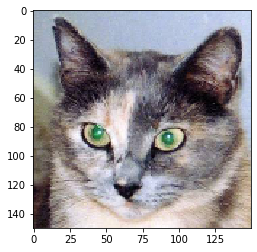

In [19]:
# 테스트 사진 출력하기
import matplotlib.pyplot as plt 
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

In [20]:
# 입력 텐서와 출력 텐서의 리스트로 모델 객체 만들기
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # 상위 8개 층의 출력을 추출
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [21]:
# 예측 모드로 모델 실행하기
activations = activation_model.predict(img_tensor)

In [22]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


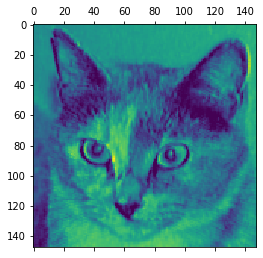

In [23]:
# 20번째 채널 시각화하기
import matplotlib.pyplot as plt 

plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

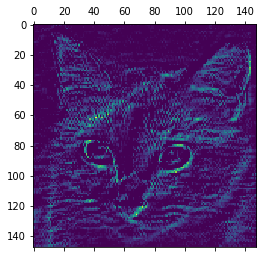

In [24]:
# 16번째 채널 시각화하기
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

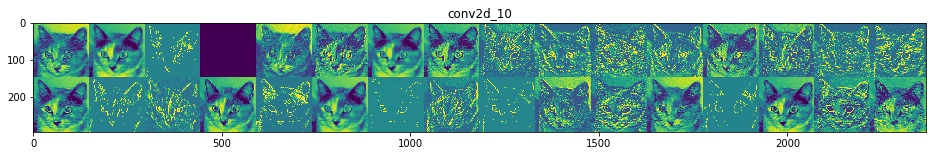

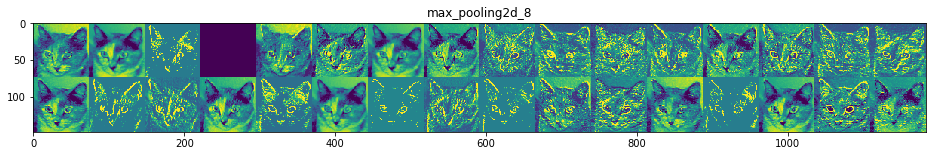

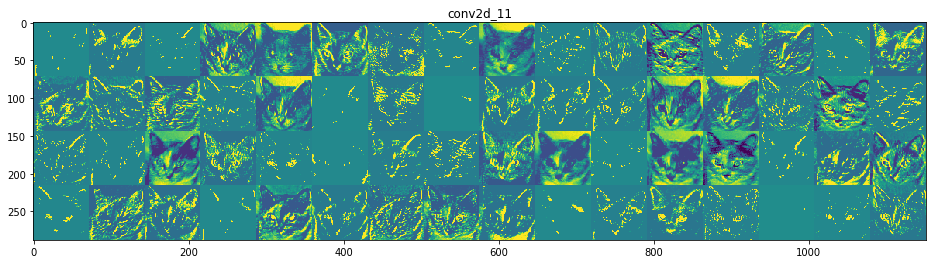

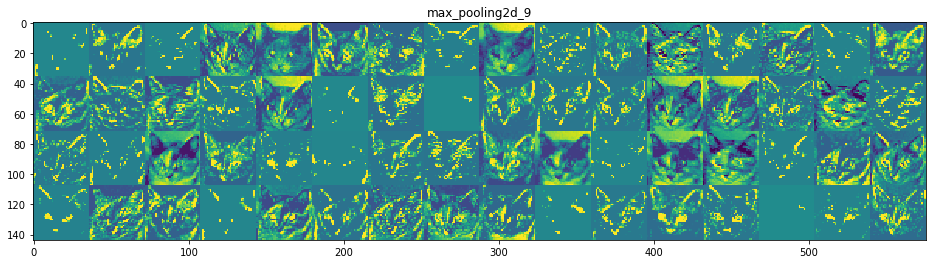

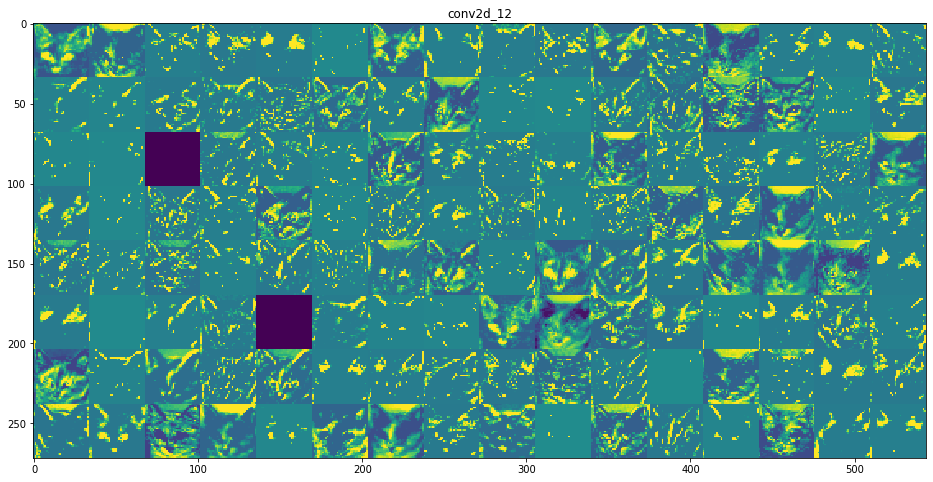

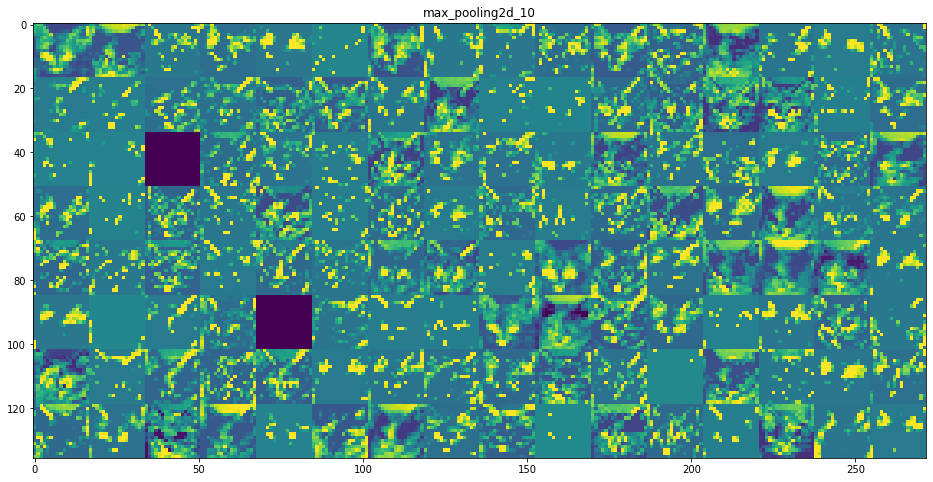

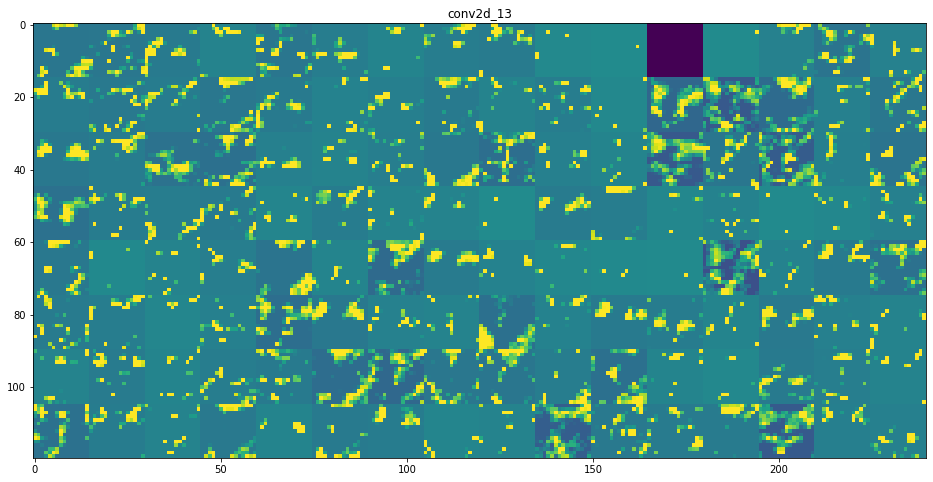

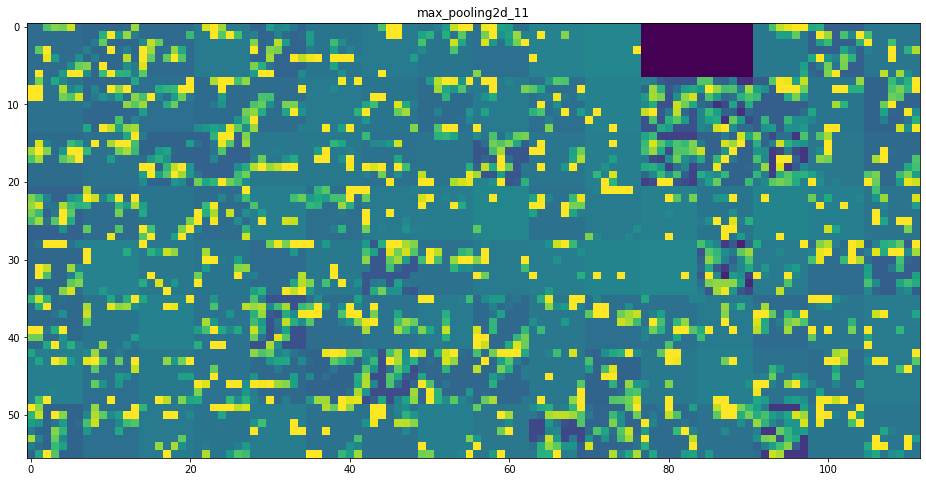

In [25]:
# 중간층의 모든 활성화에 있는 채널 시각화하기
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col*images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size : (col+1)*size, row*size: (row+1)*size] = channel_image

    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

## 컨브넷 필터 시각화하기

In [26]:
# 필터 시각화를 위한 손실 텐서 정의하기
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [27]:
# 입력에 대한 손실의 그래디언트 구하기
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

grads = K.gradients(loss, model.input)[0]

In [28]:
# 그래디언트 정규화하기
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # 0 나눗셈 방지

In [29]:
# 입력 값에 대한 넘파이 출력 값 추출하기
iterate = K.function([model.input], [loss, grads])

import numpy as np 
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

In [30]:
# 확률적 경사 상승법을 사용한 손실 최대화하기
input_img_data = np.random.random((1,150,150,3)) * 20 + 128. # 잡음이 섞인 회색 이미지로 시작

step = 1. 
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [31]:
# 텐서를 이미지 형태로 변환하기 위한 유틸리티 함수
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1 # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화

    x += 0.5
    x = np.clip(x, 0, 1) # [0,1]로 클리핑

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [32]:
# 필터 시각화 이미지를 만드는 함수
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)


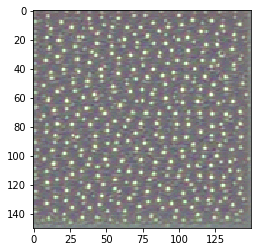

In [33]:
import matplotlib.pyplot as plt 
%matplotlib inline

plt.imshow(generate_pattern('block3_conv1', 0))

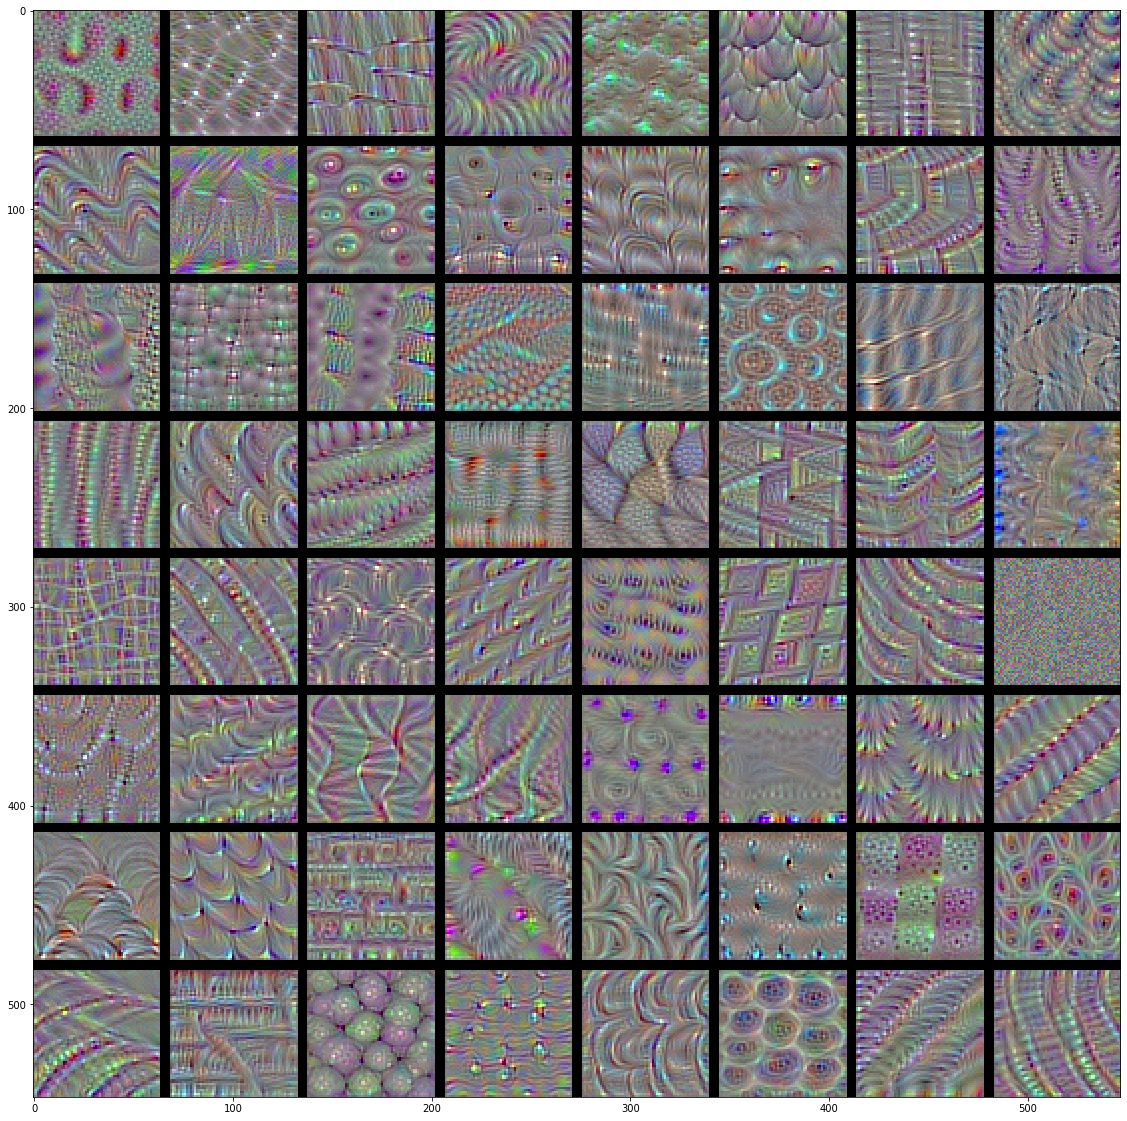

In [34]:
# 층에 있는 각 필터에 반응하는 패턴 생성하기
layer_name = 'block4_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i+(j*8), size=size)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start:horizontal_end, vertical_start:vertical_end, :] = filter_img

plt.figure(figsize=(20,20))
plt.imshow(results)

## 클래스 활성화의 히트맵 시각화하기

In [35]:
# 사전 훈련된 가중치로 VGG16 네트워크 로드하기
from keras.applications.vgg16 import VGG16

K.clear_session()

model = VGG16(weights='imagenet')

In [36]:
# VGG16 입력을 위해 입력 이미지 전처리하기
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np 

img_path = './datasets/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224,224))

x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [37]:
preds = model.predict(x)
print('Predicted: ', decode_predictions(preds, top=3)[0])

Predicted:  [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


In [38]:
np.argmax(preds[0])

386

In [39]:
# Grad-CAM 알고리즘 설정하기
# 예측 벡터의 '아프리카 코끼리' 항목
african_elephant_output = model.output[:, 386]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

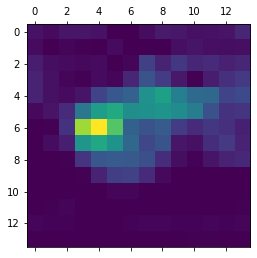

In [41]:
# 히트맵 후처리하기 0~1 정규화
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [43]:
# 원본 이미지에 히트맵 덧붙이기
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # heatmap을 원본 이미지 크기에 맞게 변경

heatmap = np.uint8(255 * heatmap) # heatmap을 RGB 포맷으로 변환

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img # 히트맵의 강도

cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

True